In [4]:
import tables as tb
import pandas as pd
omadatalocation = '/data/databases/OMA/OMA.2.1.1/data/OmaServer.h5'
#use the column dictionary from the taxonomic analysis here
import pickle
import numpy as np


In [2]:
omadata = tb.open_file(omadatalocation)

In [3]:
print(omadata.root.HogLevel.description)

Description([('Fam', '()i4'), ('ID', '()S255'), ('Level', '()S255')])


/usr/local/lib/python2.7/dist-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


In [4]:
print(omadata.root.HogLevel[0:10])

[(299330, 'HOG:0299330', 'Chromadorea')
 (299330, 'HOG:0299330', 'Pristionchus pacificus')
 (299330, 'HOG:0299330', 'Onchocercidae')
 (299330, 'HOG:0299330', 'Brugia malayi')
 (299330, 'HOG:0299330', 'Loa loa')
 (299330, 'HOG:0299330', 'Onchocerca volvulus')
 (299330, 'HOG:0299330', 'Rhabditida')
 (299330, 'HOG:0299330', 'Strongyloides ratti')
 (299330, 'HOG:0299330', 'Caenorhabditis')
 (299330, 'HOG:0299330', 'Caenorhabditis brenneri')]


<h1> Using sets to count the unique occurences in each column</h1>

In [7]:
Taxa = set([])
Hogs = set([])
Fams = set([])
rows = 0

for row in omadata.root.HogLevel:
    Taxa.add(row[2])
    Hogs.add(row[1])
    Fams.add(row[0])
    rows+=1

print(len(Taxa))
print('taxa')
print(len(Hogs))
print('Hogs')
print(len(Fams))
print('Fams')
print(rows)
print('entries')
    

2920
taxa
2715332
Hogs
589223
Fams
17467463
entries


In [8]:
import pickle
    
handle1 = open('./hogs.pkl','w')
handle2= open('./fams.pkl','w')
handle3 = open('./taxa.pkl','w')

pickle.dump(Hogs,handle1,-1)
pickle.dump(Fams,handle2,-1)
pickle.dump(Taxa,handle3,-1)

handle1.close()
handle2.close()
handle3.close()

<h1> Create a dictionary for HOGs and families </h1> The taxonomy dict isn't really necesary since we have one from the other taxonomy notebook that will be more useful in selecting our reference taxa later.

In [5]:

handle1 = open('./TAXIDtoColumn.pkl', 'r')
handle2= open('./NameToID.pkl','r')

NameToID = pickle.load(handle2, )
column_dict = pickle.load(handle1)
handle1.close()
handle2.close()


handle1 = open('./hogs.pkl','r')
handle2= open('./fams.pkl','r')
handle3 = open('./taxa.pkl','r')

Hogs = pickle.load(handle1)
Fams = pickle.load(handle2)
Taxa = pickle.load(handle3)

handle1.close()
handle2.close()
handle3.close()


handle2= open('./IdtoName.pkl','r')
IdtoName = pickle.load(handle2)
handle2.close()

coldict={}
coldictReverse = {}

for i,taxon in enumerate(Taxa):
    coldict[taxon]=i
    coldictReverse[i] = taxon
rowdict={}
rowdictReverse={}
#define a row for each unique hog
for i,hog in enumerate(Hogs):
    rowdict[hog]= i
    rowdictReverse[i]=hog
 
handle2 = open('./rowdict.pkl','w')
pickle.dump(rowdict,handle2,-1)
handle2.close()
handle2 = open('./rowdictReverse.pkl','w')
pickle.dump(rowdictReverse,handle2,-1)
handle2.close()

rowdictFam ={}
rowdictFamReverse = {}
#define a row for each unique family
#dont know if we'll use this...
for i,fam in enumerate(Fams):
    rowdictFam[fam] = i
    rowdictFamReverse[i]=fam

colmax=max(coldict.values())+1
rowmax=len(Hogs)+1

from scipy.sparse import lil_matrix

def retMatrixChunk( Hogdatachunk ):
    matrix = lil_matrix((rowmax,colmax))
    fams,hogs,taxa =Hogdatachunk
    matrix[ ([rowdict[hog] for hog in hogs] , [coldict[NameToID [taxon]] for taxon in taxa] ) ] = 1
    return matrix


def retMatrixindex( Hogdatachunk , verbose= False):
    fams,hogs,taxa =Hogdatachunk
    rows = []
    columns = []
    for i,hog in enumerate(hogs):
        taxon = taxa[i]
        rows.append(rowdict[hog])
        columns.append(coldict[taxon])
        if '.' in hog:
            keys = hog.split('.')
            newkey= keys[0]
            if verbose == True:
                print 'original :' + hog
                print newkey
            rows.append(rowdict[newkey])
            columns.append(coldict[taxon])
            for key in keys[1:-1]:
                newkey+='.'+key
                if verbose == True:
                    print newkey
                rows.append(rowdict[newkey])
                columns.append(coldict[taxon])
    return (rows , columns) 

def returnDataChunk( HogData , chunksize):
    i=0
    chunk =[]
    while len(chunk) > 0 or i == 0:
        try:
            chunk = HogData[i*chunksize:(i+1)*chunksize]
            fams,hogs,taxa = zip(*chunk)
            i +=1
            yield [fams, hogs, taxa]
        except:
            break

Just testing out the generator and the transformation to sparse matrix format. 

In [10]:
import time


it = returnDataChunk(omadata.root.HogLevel,100)

print retMatrixindex(next(it))

for x in range(10):
    start = time.clock()

    retMatrixindex(next(it))

    print(str( time.clock()-start ))


([1009873, 1009873, 1009873, 1009873, 1009873, 1009873, 1009873, 1009873, 1009873, 1009873, 1009873, 1009873, 1009873, 1009873, 447518, 447518, 447518, 447518, 447518, 447518, 34424, 34424, 34424, 1748326, 1748326, 1748326, 1748326, 508364, 508364, 508364, 2707281, 2707281, 2707281, 2707281, 2707281, 2707281, 2707281, 2707281, 2707281, 2707281, 2707281, 2707281, 2707281, 2707281, 913787, 913787, 913787, 1435396, 1435396, 1435396, 1435396, 1435396, 2551136, 2551136, 2551136, 2551136, 2551136, 2551136, 2551136, 675026, 1539931, 675026, 1539931, 675026, 1539931, 675026, 1539929, 675026, 1539929, 675026, 1539929, 675026, 675026, 675026, 675026, 675026, 675026, 2372979, 675026, 2372979, 675026, 2372979, 675026, 119156, 675026, 119156, 675026, 1128178, 1128178, 1128178, 2504876, 2504876, 2504876, 531307, 531307, 531307, 531307, 531307, 1496726, 1496726, 1496726, 1496726, 1496726, 1496726, 1496726, 1496726, 1496726, 1496726, 1496726, 1496726, 1496726], [1581, 2785, 385, 2560, 1439, 1432, 2274

<h1>Transform taxonomic levels in OMA to sparse matrix</h1>
To avoid passing vars around we'll use queues to pass chunks of OMA and return chunks of the final matrix.

Each taxonomic level corresponds to a column and each row corresponds to a HOG. This takes an hour or two to calculate for all Hogs. 

In [20]:
#return datachunks to MP function
chunksize = 50000
import multiprocessing as mp
import threading
import time
import gc
import sys 


datagenerator = returnDataChunk(omadata.root.HogLevel, chunksize ) 

def worker(q,retq,l):
    while True:
        data = q.get()
        if data == 'DONE':
            break
        indices = retMatrixindex(data)
        retq.put(indices)
        del data
        gc.collect()  

def updater(q,retq,l):
    cooevolution_matrix = lil_matrix( (rowmax,colmax) )
    while True:
        indices = retq.get()
        if indices == 'DONE':
            break
        cooevolution_matrix[indices] =  1
        del indices
        gc.collect()
    handle1=open('/data/OMAanalysis/BigCoEvMatrix.pkl' , 'w')
    pickle.dump(cooevolution_matrix,handle1, -1)
    handle1.close()
    
l = mp.Lock()
cores = mp.cpu_count()
q = mp.Queue(maxsize = 2*cores-1)
retq = mp.Queue(maxsize = 2*cores)
processes =[]
for i in range(cores*2):
    t = mp.Process(target=worker, args=(q,retq,l)  ) 
    t.daemon = True
    t.start()
    processes.append(t)

u = mp.Process(target=updater, args=(q,retq,l)  ) 
u.daemon = True
u.start()

count =0
start = 0
data = next(datagenerator)
q.put(data)
start = time.clock()


while True:
    time.sleep(.01)
    try:
        data = next(datagenerator)
        q.put(data)
        count += chunksize
        if count % (10*chunksize) == 0:
            print count
    except StopIteration:
        for p in range(len(processes)):
            q.put('DONE')
        break     
retq.put('DONE')

print 'DONE!!!!!'
#save the matrix
stop = time.clock()
print 'hours'
print (stop - start) / 3600




500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
6500000
7000000
7500000
8000000
8500000
9000000
9500000
10000000
10500000
11000000
11500000
12000000
12500000
13000000
13500000
14000000
14500000
15000000
15500000
16000000
16500000
17000000
DONE!!!!!
hours
0.172283795833


In [23]:
import pickle
handle1 =open('/data/OMAanalysis/BigCoEvMatrix.pkl' , 'r')
cooevolution_matrix = pickle.load(handle1)
print cooevolution_matrix.shape
handle1.close()

(2715333, 2920)


In [24]:

from scipy.sparse import find
import multiprocessing as mp
import time
import pickle
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus
import numpy as np
from scipy.sparse import find

import gc

def returnHashes(data, verbose= False):
    rowstart, rowend , dataChunk = data
    indices = np.vstack( find( dataChunk )).astype(np.int).T
    if verbose == True:
        print indices 
    hashes ={}
    #update hashes with presence in species
    for row in range(indices.shape[0]):
        if rowstart+indices[row,0] not in hashes:
            hashes[rowstart+indices[row,0]] = MinHash(num_perm=100)
            if verbose == True:
                print 'row '+str(rowstart+indices[row,0])
        hashes[rowstart+indices[row,0]].update(indices[row,1])
        if verbose == True:
            print indices[row,1]
    #turn to small hashes
    for key in hashes:
        hashes[key]=LeanMinHash(hashes[key])
    
    del dataChunk
    gc.collect()
    return hashes

def chopMatrix(bigMatrix,chunksize):
    i =0
    leftovers = bigMatrix.shape[0]%chunksize
    
    while i <  bigMatrix.shape[0] - leftovers :
        chunk = bigMatrix[i:i+chunksize,:]
        yield [i,i+chunksize,chunk]
        i+=chunksize
    yield [i,i+leftovers,bigMatrix[i:i+leftovers,:]]
    
    


<h1> test out the generator and Hashing functions </h1>
The generator chops a matrix into blocks of Nrows. The hashing function assigns hash to each HOG rownumber and updates it based on which columns are positive. When the updates are finished the hash is turned to a LeanMinHash with a smaller memory footprint


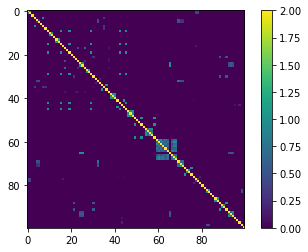

In [25]:
import time
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus
from matplotlib import pyplot as plt

data = next(chopMatrix(cooevolution_matrix,100))
start = time.clock()
hashes  = returnHashes(data, verbose= False)

dist = np.zeros((len(hashes), len(hashes)))
for i in range(len(hashes)):
    for j in range(len(hashes)):
        if i <=j:
            keyi = hashes.keys()[i]
            keyj = hashes.keys()[j]
            dist[i,j]= hashes[keyi].jaccard(hashes[keyj])

dist += dist.T
plt.imshow(dist)
plt.colorbar()
plt.show()


In [26]:
print len(hashes)
forest = MinHashLSHForest( num_perm=100 )
for key in hashes:
    forest.add(  key , hashes[key] )
print (hashes.keys()[0] in forest)
forest.index()
result = forest.query(hashes[hashes.keys()[0]],10)
print result

100
True
[0, 1, 77, 78]


<h1>  calculate a hash for each HOG</h1> the same multiprocessing strategy as before 

The top N neighbors for each HOG can be used as a threshold to avoid calculating other more costly distance metrics for all the HOGs vs all the HOGs.



In [ ]:
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus
import multiprocessing as mp
import gc
import numpy as np
import redis

#use min hashing to generate a hash for each HOG and an LSH forest with all hashes
#use the jackard distance with LSH forest to grab top N hits for each HOG-> use as threshhold for distance matrices
#works with redis to store hash values

def worker(q,retque,l):
    while True:
        time.sleep(.01)
        data = q.get()
        if data == 'DONE':
            break
        obj = returnHashes(data)
        print 'done hashing'
        retq.put(obj)
        del obj
        del data
        gc.collect()
       

def updater(r,q,retq,l):
    i=0
    while True:
        data = retq.get()
        if data == 'DONE':
            break
        for key in data:
            r.set(key, pickle.dumps(data[key]))
        i +=1
        print 'update done'
        del data
        gc.collect()

chunksize = 10000
l = mp.Lock()
cores = mp.cpu_count()
q = mp.Queue(maxsize = cores/4)
retq = mp.Queue(maxsize = cores/4)
iterator = chopMatrix(cooevolution_matrix,chunksize)
r = redis.StrictRedis(host='localhost', port=6379, db=0)


processes =[]
for i in range(cores/4):
    t = mp.Process(target=worker, args=(q,retq,l)  ) 
    t.daemon = True
    t.start()
    u = mp.Process(target=updater, args=(r,q,retq,l)  ) 
    u.daemon = True
    u.start()
    processes.append(t)
    processes.append(u)
    count =0
while q.empty()==False or count == 0:
    time.sleep(.1)
    while True:
        count += 1
        try:
            data = next(iterator)
            print data
            q.put(data)
        except StopIteration:
            break
for p in processes:
    q.put('DONE')
q.close()
retq.close()
print 'DONE!!!!!'


[0, 10000, <10000x2920 sparse matrix of type '<type 'numpy.float64'>'
	with 98276 stored elements in LInked List format>]
[10000, 20000, <10000x2920 sparse matrix of type '<type 'numpy.float64'>'
	with 92951 stored elements in LInked List format>]
[20000, 30000, <10000x2920 sparse matrix of type '<type 'numpy.float64'>'
	with 97995 stored elements in LInked List format>]
[30000, 40000, <10000x2920 sparse matrix of type '<type 'numpy.float64'>'
	with 101769 stored elements in LInked List format>]
[40000, 50000, <10000x2920 sparse matrix of type '<type 'numpy.float64'>'
	with 99191 stored elements in LInked List format>]
[50000, 60000, <10000x2920 sparse matrix of type '<type 'numpy.float64'>'
	with 102463 stored elements in LInked List format>]
[60000, 70000, <10000x2920 sparse matrix of type '<type 'numpy.float64'>'
	with 108375 stored elements in LInked List format>]
[70000, 80000, <10000x2920 sparse matrix of type '<type 'numpy.float64'>'
	with 92138 stored elements in LInked List fo

In [4]:
#build the forest
import pickle

import redis 
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus
r = redis.StrictRedis(host='localhost', port=6379, db=0)
forest = MinHashLSHForest(num_perm=100)
iterator = r.scan_iter()
for i,key in enumerate(iterator):
    hashval = pickle.loads(r.get(key))
    forest.add(key, hashval)
forest.index()

with open( '/data/OMAanalysis/ForestALL.pkl', 'w') as forestfile:
    pickle.dump(forest, forestfile, -1)

In [5]:
import pickle

with open( '/data/OMAanalysis/ForestALL.pkl', 'r') as forestfile:
    forest = pickle.load(forestfile)

with open('/data/OMAanalysis/BigCoEvMatrix.pkl' , 'r') as handle1:
    cooevolution_matrix = pickle.load(handle1)

handle2 = open('./rowdict.pkl','r')
rowdict = pickle.load(handle2)
handle2.close()

handle2 = open('./rowdictReverse.pkl','r')
rowdictReverse = pickle.load(handle2)
handle2.close()

In [6]:
from matplotlib import pyplot as plt
from matplotlib import pylab

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy as np
import redis
r = redis.StrictRedis(host='localhost', port=6379, db=0)

from scipy.sparse import find

def plot_NN(qhog,k, r, cooevolution_matrix  ):
    print 'query ' + qhog
    hashval = pickle.loads(r.get(rowdict[qhog]))
    result = forest.query(  hashval , k )
    resultHogs= np.asarray([qhog]+[rowdictReverse[int(row)] for row in result ])
    hashes = []
    hashes.append(hashval)
    for hog in result:
        hashval = pickle.loads(r.get(hog))
        hashes.append(hashval)
    dist = np.zeros((len(hashes), len(hashes)))
    for i in range(len(hashes)):
        for j in range(len(hashes)):
            if i <=j:
                dist[i,j]= hashes[i].jaccard(hashes[j])

    #show similar profiles
    dist += dist.T
    clustering = np.argsort(dist[0,:])[::-1]
    dist = dist[clustering,:]
    dist = dist[:,clustering]
    resultHogs = resultHogs[clustering]
    print resultHogs
    print 'phylo signatures'
    result_mat = cooevolution_matrix[np.asarray([int(rowdict[qhog])]+ [int(res) for res in result ] ),:]
    result_mat=result_mat[clustering,:].T
    x,y,vals = find(result_mat)
    #%pylab inline
    pylab.rcParams['figure.figsize'] = (10, 20)
    fig = plt.figure()
    ax = fig.add_subplot(111 )
    ax.scatter(x,y, s = .4)
    ax.set_yticks(range(result_mat.shape[1]))
    ax.set_yticklabels(list(resultHogs))
    
    
    plt.show()
    
  
    plt.clf()
    return resultHogs , result_mat
    





Hap2 network
query HOG:0385024


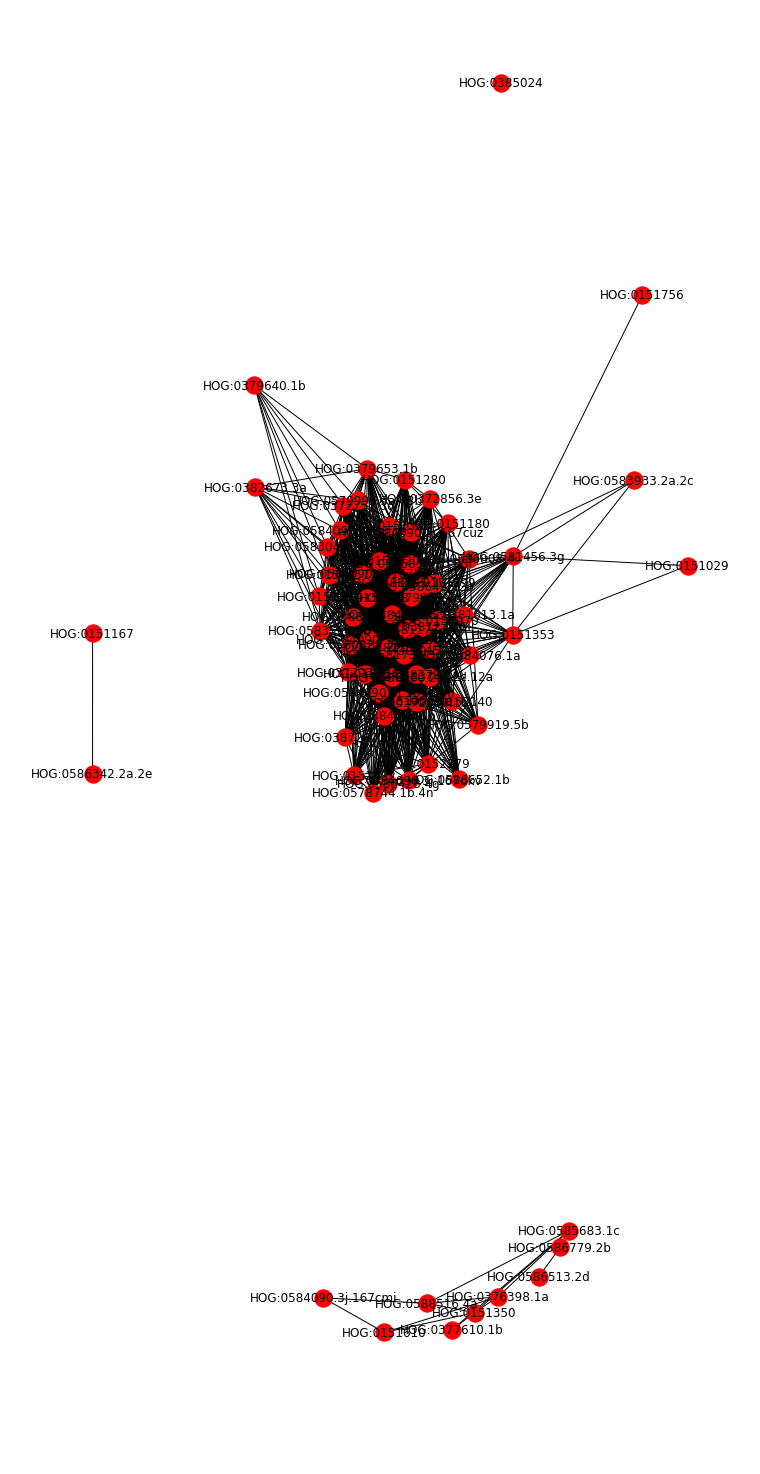

In [22]:
import networkx as nx
def subnetwork(qhog, k , r,thresh):
    print 'query ' + qhog
    hashval = pickle.loads(r.get(rowdict[qhog]))
    result = forest.query(  hashval , k )
    Hogdict = {}
    resultHogs= np.asarray([qhog]+[rowdictReverse[int(row)] for row in result ])

    Hogdict[qhog] = hashval
    hashes =[]
    for hog in result:
        hashval = pickle.loads(r.get(hog))
        hashes.append(hashval)
    dist = np.zeros((len(hashes), len(hashes)))
    for i in range(len(hashes)):
        for j in range(len(hashes)):
            if i <j:
                dist[i,j]= hashes[i].jaccard(hashes[j])           
    #show similar profiles
    dist += dist.T
    clustering = np.argsort(dist[0,:])[::-1]
    dist = dist[clustering,:]
    dist = dist[:,clustering]
    
    resultHogs = resultHogs[clustering]
        
    for hog in result:
        Hogdict[rowdictReverse[int(hog)]]= pickle.loads(r.get(hog))
    G = nx.Graph( sizes = [] , colors = [], widths = [])
    G.add_node(qhog,{ 'color':'blue' , 'size':20 } )
    for i, one in enumerate(Hogdict):
        for j, two in enumerate(Hogdict):
            if i < j:
                score = Hogdict[one].jaccard(Hogdict[two])
                if score > thresh:
                    G.add_nodes_from([one,two])
                    if one != qhog:
                        G.node[one]['size']= 10
                        G.node[one]['color']= 'red'
                    if two != qhog:
                        G.node[two]['size']= 10
                        G.node[two]['color']= 'red'
                    G.add_edge(one,two ,{'jaccard':score})
    colors = [ G.node[x]['color'] for x in G.nodes()]
    sizes = [G.node[x]['size']  for x in G.nodes()]
    widths = [G.edge[x[0]][x[1]]['jaccard'] for x in G.edges()]
    G.graph['sizes']= sizes
    G.graph['colors']=colors
    G.graph['widths']= widths
    return G

def show3d( result_mat , resultHogs):
    with open('./embeddings3d.pkl' , 'r') as embeddings:
        species3d = pickle.load(embeddings)
    with open('./IDtoColor.pkl' , 'r') as colors:
        colorsdict = pickle.load(colors)
    with open('./ColumntoTAXID.pkl' , 'r') as colmap:
        taxids = pickle.load(colmap)
    with open('./embeddings3d.pkl' , 'r') as embeddings:
        species3d = pickle.load(embeddings)
    print 'species tree distribution'
    for i in range(5):
        #plot 3d species tree for top 5
        x,y,vals=find(result_mat[:,i])
        selected = species3d[x,:]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d' )
        matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
        if i == 0:
            ax.set_title('query' +resultHogs[i])
        else:
            ax.set_title('result' +resultHogs[i])

        ax.scatter( selected[:,0], selected[:,1], selected[:,2], marker= 'D' , color = 'red')#, color = [colors[taxids[col]] for col in list(x)])
        species3d[x,:]=0
        ax.scatter( species3d[:,0], species3d[:,1], species3d[:,2] , alpha= .05 , color ='green' )#, color = [colors[taxids[col]] for col in list(x)])
        plt.show()
        
        
print 'Hap2 network'
qhog = 'HOG:0385024'
subgraph = subnetwork(qhog, 100 , r , .95 )

nx.draw(subgraph, with_labels = True)#, node_size = subgraph.graph['sizes'] , linewidths = [ edge['jaccard'] for edge in subgraph.edges()] )

plt.show()


query HOG:0385024
['HOG:0385024' 'HOG:0385024' 'HOG:0380874' 'HOG:0580811.3bd' 'HOG:0373738'
 'HOG:0586513.2d' 'HOG:0386211' 'HOG:0386157' 'HOG:0151167' 'HOG:0381468'
 'HOG:0586779.2b' 'HOG:0379069' 'HOG:0586342.2a.2e' 'HOG:0387261'
 'HOG:0583887.3m' 'HOG:0586652.1b' 'HOG:0382629.2b' 'HOG:0151350'
 'HOG:0376355' 'HOG:0151648' 'HOG:0151610' 'HOG:0376398.1a' 'HOG:0379102'
 'HOG:0585683.1c' 'HOG:0580428.4g' 'HOG:0388332.3q' 'HOG:0152140'
 'HOG:0379973.4d' 'HOG:0382204.2r' 'HOG:0578744.1b.4n' 'HOG:0377610.1b'
 'HOG:0386860.2b' 'HOG:0151970' 'HOG:0584090.3j.167cuz' 'HOG:0381066.2a'
 'HOG:0584090.3j.167dwl' 'HOG:0372088.1b' 'HOG:0151582' 'HOG:0379692.2a'
 'HOG:0583742.2c.12a' 'HOG:0381279.1i' 'HOG:0384121.3c' 'HOG:0380972'
 'HOG:0584090.3j.167cmi' 'HOG:0152279' 'HOG:0151599' 'HOG:0372033.1c'
 'HOG:0378210' 'HOG:0386495.2b' 'HOG:0581733.3c.71c' 'HOG:0583395.3d'
 'HOG:0383792.4u' 'HOG:0152618' 'HOG:0581177.1a' 'HOG:0152567'
 'HOG:0152608' 'HOG:0584090.3j.167eam' 'HOG:0586855.3d.65r'
 'HOG:0584

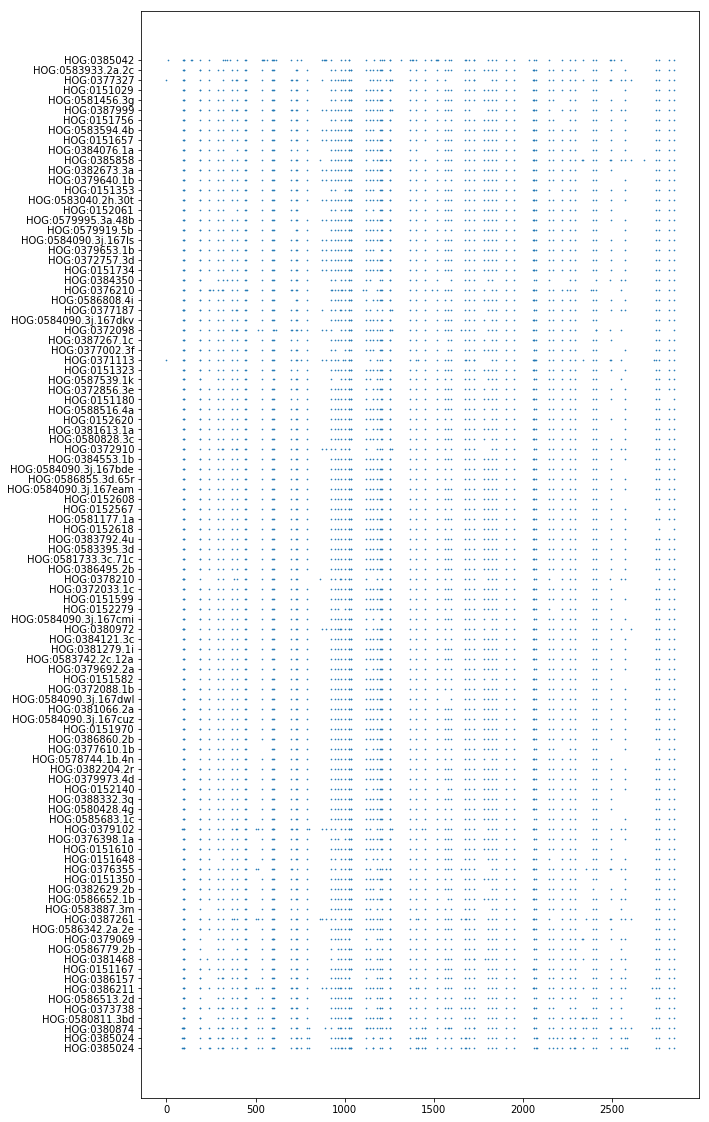

query HOG:0385024


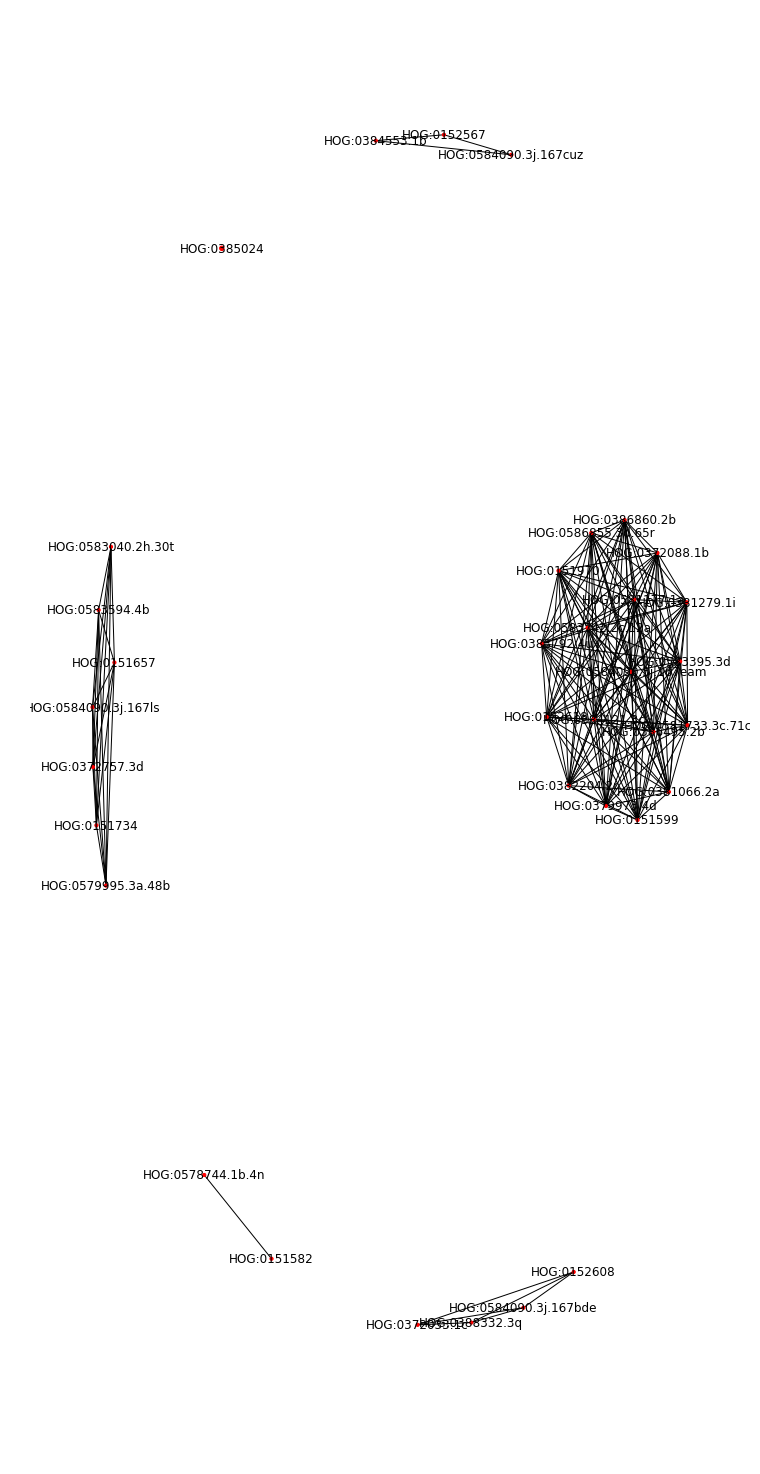

query HOG:0374514
['HOG:0374514' 'HOG:0382906.3f.19c' 'HOG:0372757.3a.2b'
 'HOG:0578823.3m.25b' 'HOG:0586573.2a.17am.55a' 'HOG:0150494'
 'HOG:0581043.3k.7b' 'HOG:0582933.2d.5cu' 'HOG:0150452'
 'HOG:0379231.3f.13b' 'HOG:0582532.1b.2a.2c' 'HOG:0383409.3e.8b'
 'HOG:0150113' 'HOG:0580811.3s.237ci.2085d' 'HOG:0579727.2h.28f.17c'
 'HOG:0388062.2b' 'HOG:0383652.8b' 'HOG:0386517.3a' 'HOG:0375871.1a.1e'
 'HOG:0150446' 'HOG:0373101.2b.5b' 'HOG:0150429' 'HOG:0387570'
 'HOG:0582280.3c' 'HOG:0381817.2e' 'HOG:0150336' 'HOG:0150984'
 'HOG:0150302' 'HOG:0150249' 'HOG:0150936' 'HOG:0150846'
 'HOG:0584329.4b.7a' 'HOG:0388666' 'HOG:0372096' 'HOG:0150040'
 'HOG:0579991.3b.3b' 'HOG:0579552.13b' 'HOG:0372113' 'HOG:0381259.3a.4b'
 'HOG:0150244' 'HOG:0383584.1b.1b' 'HOG:0150944' 'HOG:0150820'
 'HOG:0149846' 'HOG:0149917' 'HOG:0384229.2b' 'HOG:0386106.1b'
 'HOG:0386157' 'HOG:0588805.1b.4a.7d' 'HOG:0150553' 'HOG:0374145.1b.1c'
 'HOG:0150447' 'HOG:0150979' 'HOG:0149850' 'HOG:0150765'
 'HOG:0588952.3b.34c.178d' '

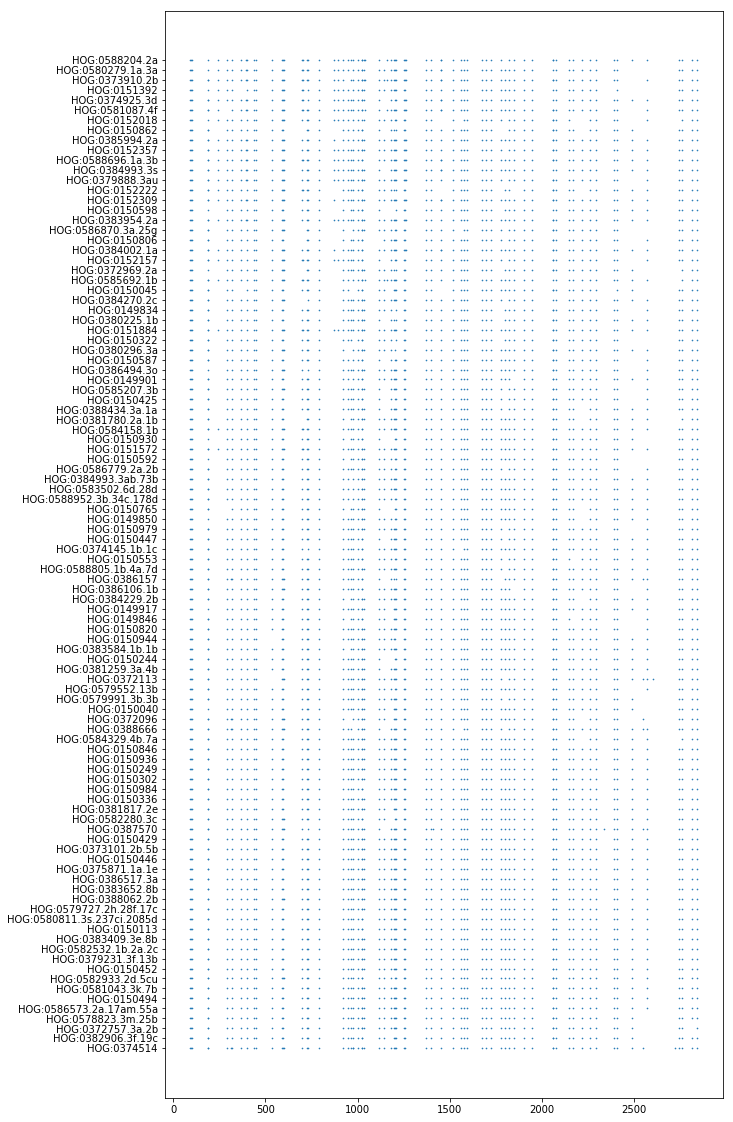

query HOG:0374514


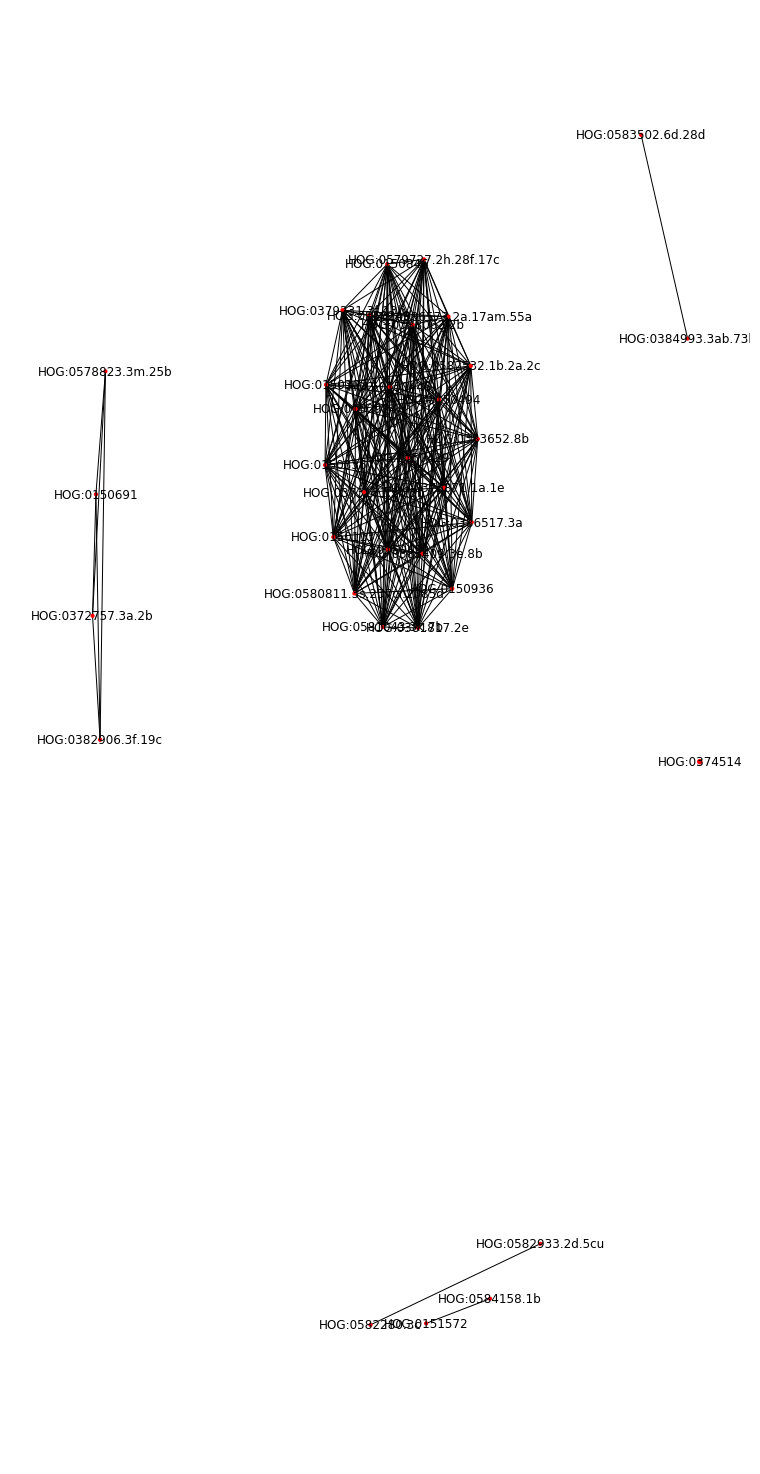

query HOG:0262715
['HOG:0262715' 'HOG:0262715' 'HOG:0379484.7c.22c.17a.7b.4a'
 'HOG:0372120.7e.11b.14a.13a' 'HOG:0261754' 'HOG:0263316' 'HOG:0262402'
 'HOG:0388175.3b.6b.11d.8a' 'HOG:0372392.4h.6b.3c.4a.1b' 'HOG:0259090'
 'HOG:0587040.3d.18a.16c' 'HOG:0266000.1a'
 'HOG:0584090.3j.173fpj.4800b.5103b' 'HOG:0373779.9b.38a' 'HOG:0255777'
 'HOG:0256211' 'HOG:0256617' 'HOG:0580811.3s.243bs.2312g.2658a'
 'HOG:0350654.1a.1b' 'HOG:0260177.1a'
 'HOG:0383792.10m.76a.85b.80b.34b.18b.1c' 'HOG:0266113.1a'
 'HOG:0582130.3a.115ar.1045m.1180m.604b.94d' 'HOG:0583987.2b.23c.12a.25b'
 'HOG:0578516.1a.10i.87b.70a.87b' 'HOG:0382906.9j.33a.11d'
 'HOG:0374938.3c.3b.1b.2d' 'HOG:0256490'
 'HOG:0584090.3j.173adw.4120l.4503d.3177b.1948d.926r.460g.264c.41c'
 'HOG:0257174' 'HOG:0259490.1b' 'HOG:0256458' 'HOG:0387120.2c.7b.3a'
 'HOG:0588096.3e.54b.161a.150a.59b' 'HOG:0257110' 'HOG:0256297'
 'HOG:0257653' 'HOG:0256898'
 'HOG:0582130.3ab.166f.1460i.1809b.1115k.462a.335d.184a' 'HOG:0264286.1a'
 'HOG:0386634.1b.7a.3b.1b

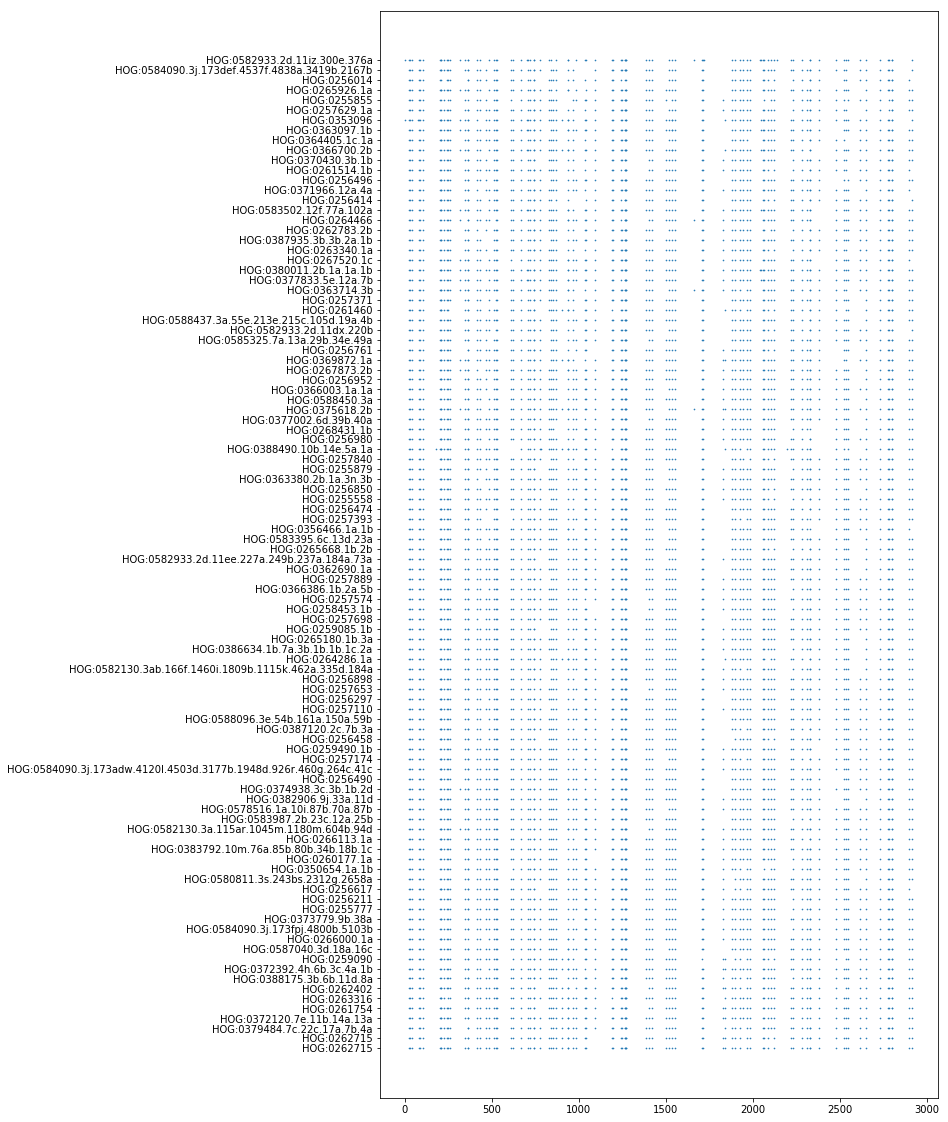

query HOG:0262715


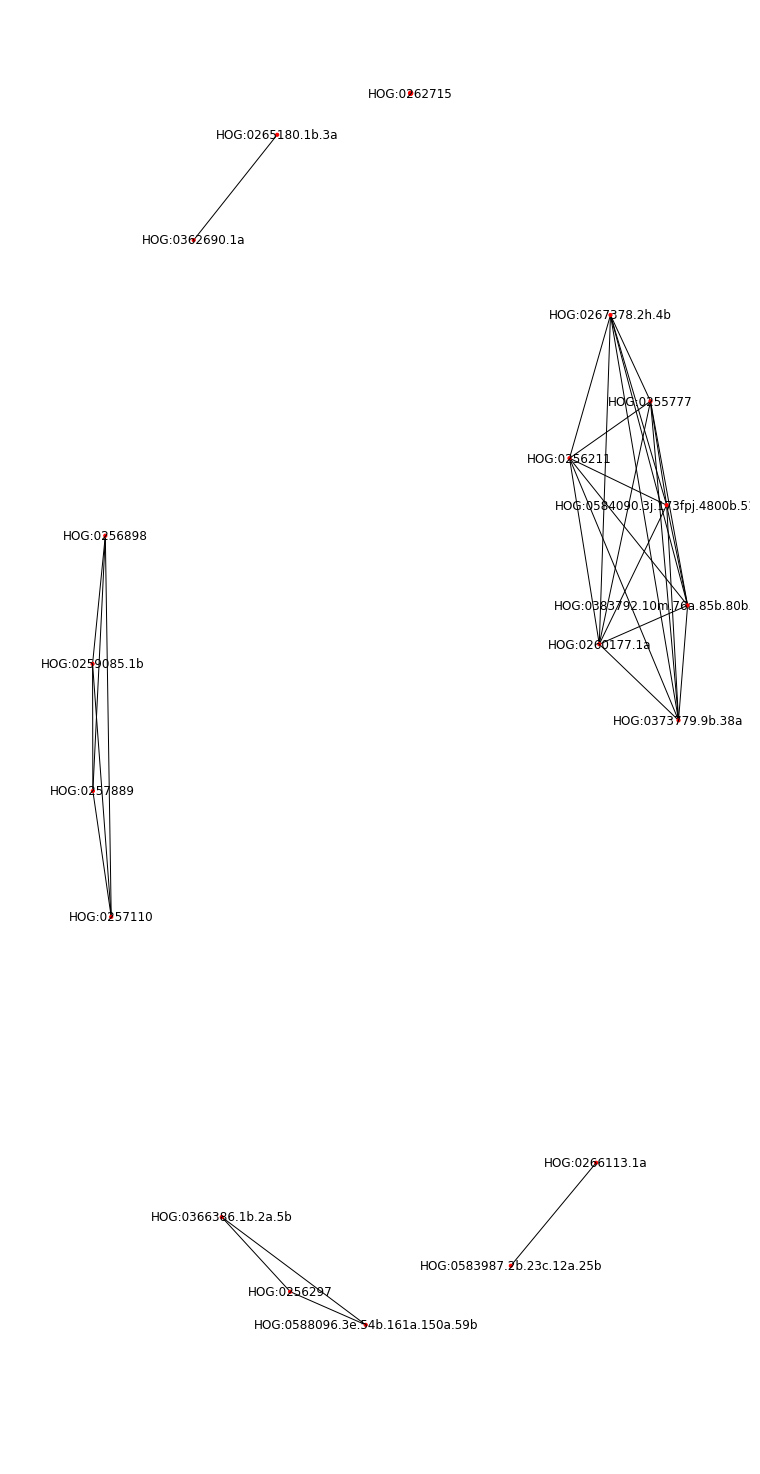

In [23]:


#hap2 HOG:0385024\
plt.clf()
qhog = 'HOG:0385024'
resultHogs, resultmat = plot_NN(qhog, 99, r , cooevolution_matrix)
plt.show()
subgraph = subnetwork(qhog, 100 , r , .99 )
nx.draw(subgraph, with_labels = True, node_size = subgraph.graph['sizes'] )#, linewidths = [ edge['jaccard'] for edge in subgraph.edges()] )

plt.show()



#gex1 HOG:0374514
qhog = 'HOG:0374514'
resultHogs, resultmat = plot_NN(qhog, 99, r , cooevolution_matrix)
plt.show()
subgraph = subnetwork(qhog, 100 , r , .99 )

nx.draw(subgraph, with_labels = True, node_size = subgraph.graph['sizes'] )#, linewidths = [ edge['jaccard'] for edge in subgraph.edges()] )
plt.show()



#zp2
qhog = 'HOG:0262715'
resultHogs, resultmat = plot_NN(qhog, 99, r , cooevolution_matrix)
plt.show()
subgraph = subnetwork(qhog, 100 , r , .99 )
nx.draw(subgraph, with_labels = True, node_size = subgraph.graph['sizes'] )#, linewidths = [ edge['jaccard'] for edge in subgraph.edges()] )
plt.show()


query HOG:0273533
['HOG:0273533' 'HOG:0278985' 'HOG:0271286' 'HOG:0362997.2b.1d.2b'
 'HOG:0271799' 'HOG:0281848' 'HOG:0287285.1b' 'HOG:0276755' 'HOG:0281218'
 'HOG:0273097' 'HOG:0353380.1a' 'HOG:0272506' 'HOG:0277858'
 'HOG:0342978.1f.4c' 'HOG:0270542' 'HOG:0272701' 'HOG:0270602'
 'HOG:0281832' 'HOG:0281234' 'HOG:0270291' 'HOG:0276049' 'HOG:0271090'
 'HOG:0372928.5b' 'HOG:0276376' 'HOG:0582463.6c.27b.28b.24b' 'HOG:0276788'
 'HOG:0367695.1b.4a.1b.1a.1a' 'HOG:0278114' 'HOG:0273419'
 'HOG:0342978.1c.1ak.5a' 'HOG:0273186' 'HOG:0371294.7a' 'HOG:0270538'
 'HOG:0275717' 'HOG:0272266' 'HOG:0280530' 'HOG:0273928'
 'HOG:0584501.2b.1c' 'HOG:0280294' 'HOG:0272403' 'HOG:0282040'
 'HOG:0278320' 'HOG:0274894' 'HOG:0279958' 'HOG:0278220' 'HOG:0277441'
 'HOG:0273869' 'HOG:0275142' 'HOG:0383980.2b' 'HOG:0281337' 'HOG:0276013'
 'HOG:0276082' 'HOG:0271232' 'HOG:0275029' 'HOG:0277853' 'HOG:0287329.1a'
 'HOG:0275094' 'HOG:0276568' 'HOG:0278560' 'HOG:0360569.2a.2g.6d'
 'HOG:0282293' 'HOG:0273744' 'HOG:028177

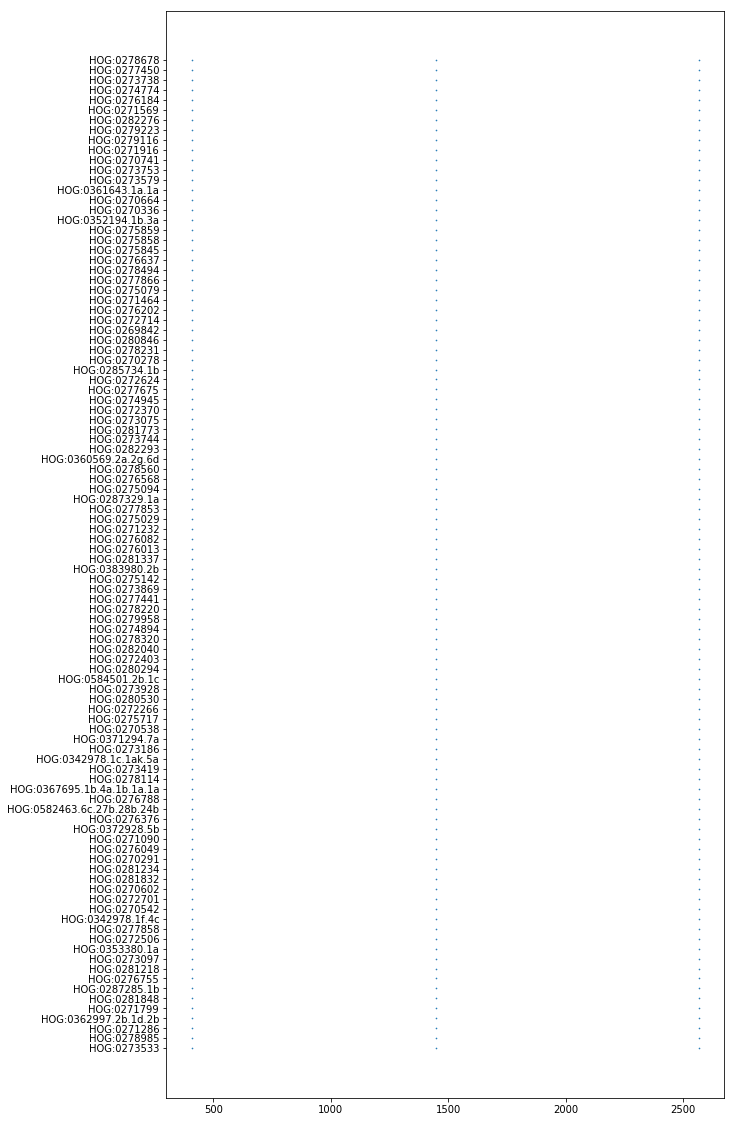

query HOG:0273533


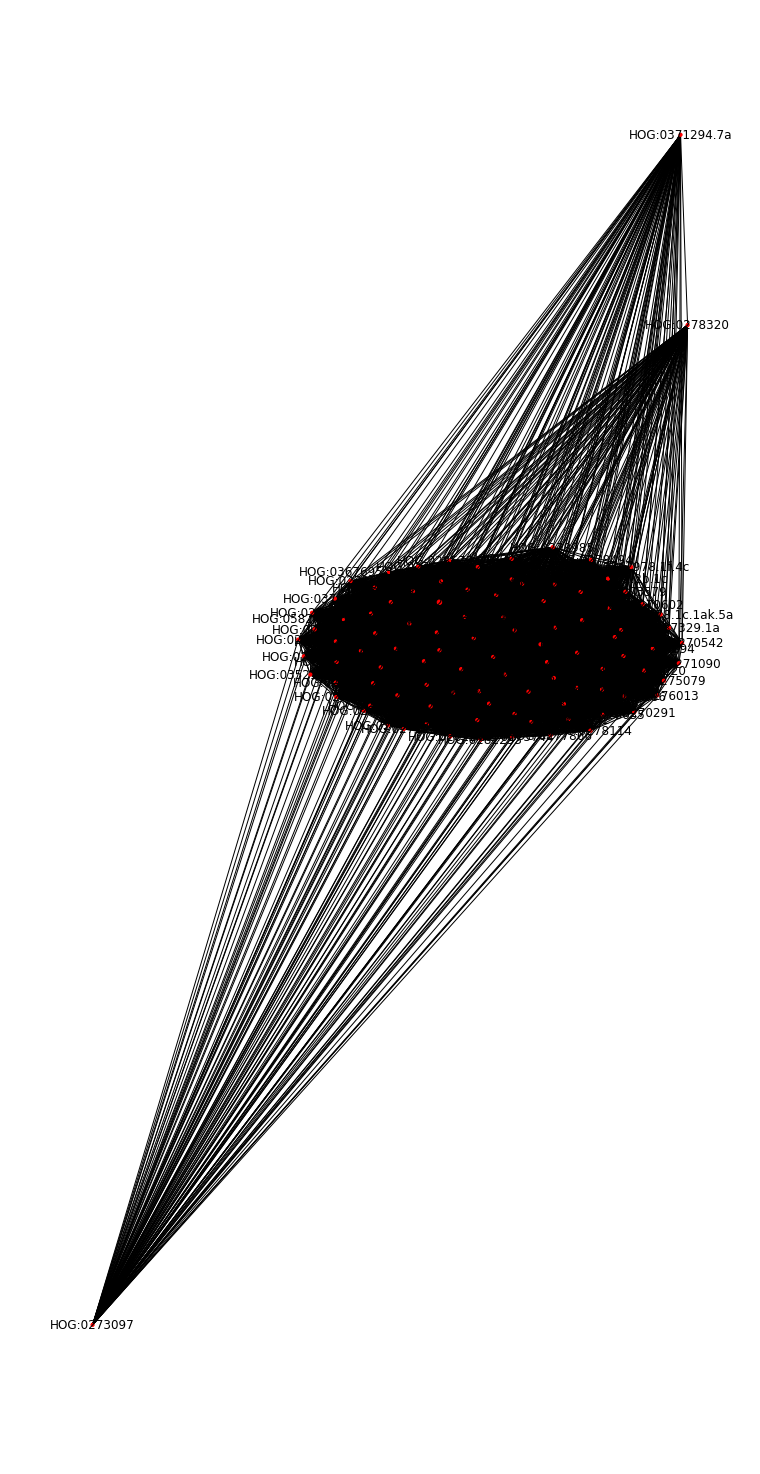

In [30]:

#synaptobrevin
qhog = 'HOG:0273533'
plt.clf()
resultHogs, resultmat = plot_NN(qhog, 99, r , cooevolution_matrix)
plt.show()
subgraph = subnetwork(qhog, 100 , r , .99 )
nx.draw(subgraph, with_labels = True, node_size = subgraph.graph['sizes'] )#, linewidths = [ edge['jaccard'] for edge in subgraph.edges()] )
plt.show()


query HOG:0374514


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:141: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


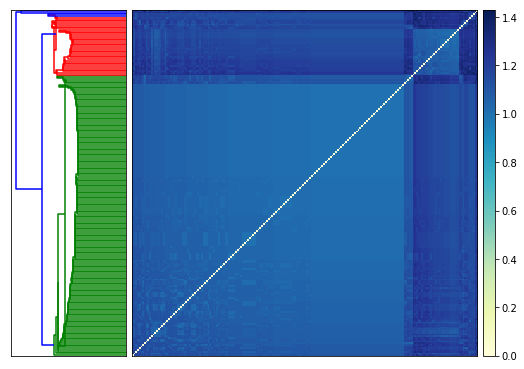

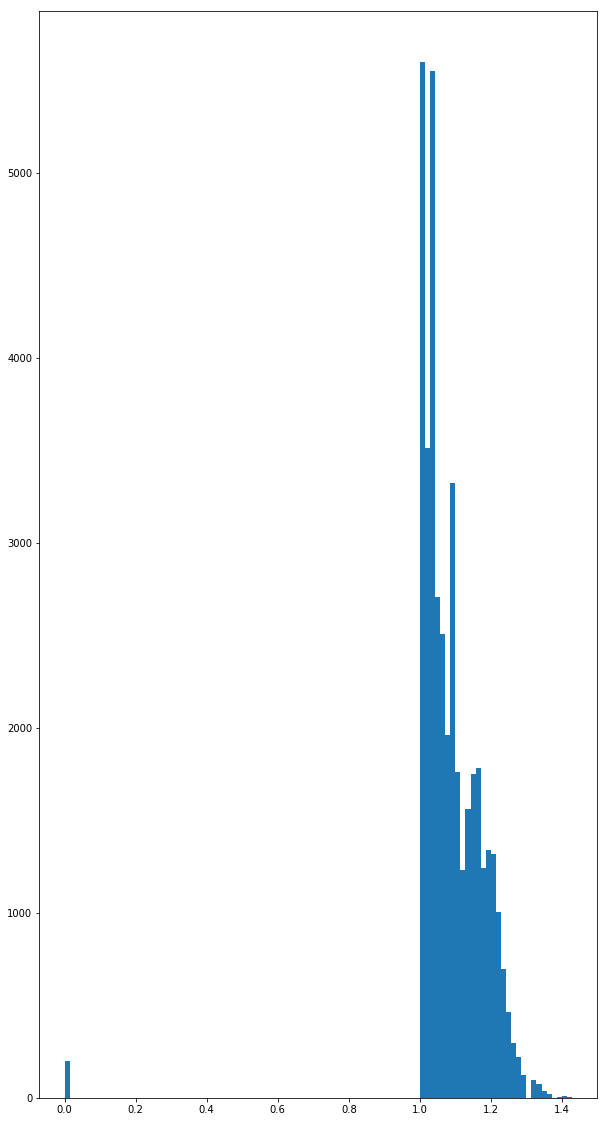

dist to qhog


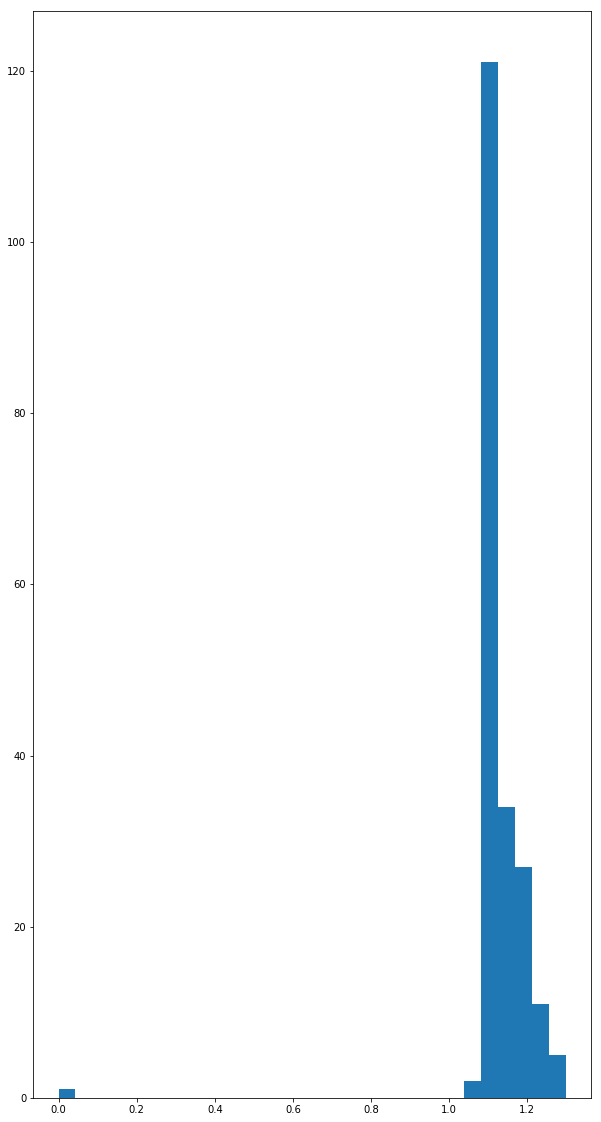

query HOG:0374514


OSError: [Errno 12] Cannot allocate memory

In [45]:

#kolmogrov compression based MI for two profiles.
import zlib
import networkx as nx
from matplotlib import pyplot as plt
from scipy.sparse import find 
import multiprocessing as mp
import redis


import scipy
import pylab
import scipy.cluster.hierarchy as sch


r = redis.StrictRedis(host='localhost', port=6379, db=0)


def MI( row1, row2 , mapping = None):
    row1 =find(row1)[0]
    row2 = find(row2)[0]
    if mapping == 'species':
        taxIDs1 = np.vectorize(coldictReverse.get)(row1)
        taxIDs2 = np.vectorize(coldictReverse.get)(row2)
        taxa2 = np.vectorize(IdtoName.get)(taxIDs2)
        taxa1 = np.vectorize(IdtoName.get)(taxIDs1)
        str1=np.array2string(taxa1)
        str2=np.array2string(taxa2)
    else:
        taxIDs1 = np.vectorize(coldictReverse.get)(row1)
        taxIDs2 = np.vectorize(coldictReverse.get)(row2)
        str1=np.array2string(taxIDs1)
        str2=np.array2string(taxIDs2)
    MI = float( len(zlib.compress(str1+str2) ) ) / ( len(zlib.compress(str1)) + len(zlib.compress(str2))  )
    return MI

def MImulti(args):
    row1,row2,mapping =args
    return MI(row1,row2,mapping)

def rowpairGen(cooevolution_matrix , rows , kwargs=None):
    dist = np.zeros((len(rows),len(rows)), dtype='float64')
    for i,row1 in enumerate(rows):
        for j,row2 in enumerate(rows):
            if i <=j:
                yield (cooevolution_matrix[int(row1),:], cooevolution_matrix[int(row2),:] , kwargs)

def normalizeByDiag(dist):
    for i in range(dist.shape[0]):
        for j in range(dist.shape[0]):
            if i<j:
                diag1 = dist[i,i]
                diag2 = dist[j,j]
                avg = (diag1+diag2)/2
                dist[i,j] /= avg
                dist[j,i] /= avg
    np.fill_diagonal(dist,1)
    return dist

def jaccardDist(qhog,r,forest,cooevolution_matrix , k=200 ):
    print 'query ' + qhog
    hashval = pickle.loads(r.get(rowdict[qhog]))
    result = forest.query(  hashval , k )
    resultHogs= np.asarray([qhog]+[rowdictReverse[int(row)] for row in result ])
    hashes = []
    hashes.append(hashval)
    for hog in result:
        hashval = pickle.loads(r.get(hog))
        hashes.append(hashval)
    dist = np.zeros((len(hashes), len(hashes)))
    for i in range(len(hashes)):
        for j in range(len(hashes)):
            if i <=j:
                dist[i,j]= hashes[i].jaccard(hashes[j])
    #show similar profiles
    dist += dist.T
    dist[np.diag_indices_from(dist)] /= 2
    dist = normalizeByDiag(dist)
    clustering = np.argsort(dist[0,:])[::-1]
    dist = dist[clustering,:]
    dist = dist[:,clustering]
    resultHogs = resultHogs[clustering]
    return dist, resultHogs

def MIdist(qhog,r,forest,cooevolution_matrix , k=200 , mapping = None):
    print 'query ' + qhog
    hashval = pickle.loads(r.get(rowdict[qhog]))
    result = forest.query(  hashval , k )
    resultHogs= np.asarray([qhog]+[rowdictReverse[int(row)] for row in result ])
    rows = [rowdict[qhog]]+result
    dist = np.zeros((len(rows),len(rows)), dtype='float64')
    for i,row1 in enumerate(rows):
        for j,row2 in enumerate(rows):
            if i <= j:
                dist[i,j] = MI(cooevolution_matrix[int(row1),:], cooevolution_matrix[int(row2),:], mapping)
    dist[np.diag_indices_from(dist)] /= 2
    dist+= dist.T
    dist = normalizeByDiag(dist)
    clustering = np.argsort(dist[0,:])[::-1]
    dist = dist[clustering,:]
    dist = dist[:,clustering]
    resultHogs = resultHogs[clustering]
    return dist , resultHogs

def MIdistMulti(qhog,r,forest,cooevolution_matrix , k=200 , mapping = None):
    #unfinished
    print 'query ' + qhog
    hashval = pickle.loads(r.get(rowdict[qhog]))
    result = forest.query(  hashval , k )
    resultHogs= np.asarray([qhog]+[rowdictReverse[int(row)] for row in result ])
    rows = [rowdict[qhog]]+result
    dist = np.zeros((len(rows),len(rows)), dtype='float64')
    pool = mp.Pool()
    
    distances = pool.map(MImulti,rowpairGen(cooevolution_matrix, rows ,{'mapping':mapping} ), 200 )
    dist = np.zeros((len(rows),len(rows)), dtype='float64')
    distIter = iter(distances)
    for i,row1 in enumerate(rows):
        for j,row2 in enumerate(rows):
            if i <=j:
                dist[i,j]= next(distIter)
    dist+= dist.T
    dist = normalizeByDiag(dist)
    
    
    clustering = np.argsort(dist[0,:])[::-1]
    dist = dist[clustering,:]
    dist = dist[:,clustering]
    resultHogs = resultHogs[clustering]
    
    
    return dist , resultHogs

def showdistmat(D):
    
    plt.clf()
    fig = pylab.figure(figsize=(8,8))
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
    D=1/D
    np.fill_diagonal(D,0)
    Y = sch.linkage(D, method='centroid')
    Z1 = sch.dendrogram(Y, orientation='left')
    ax1.set_xticks([])
    ax1.set_yticks([])


    # Plot distance matrix.
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
    idx1 = Z1['leaves']
    #idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx1]
    
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
    
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])
    
    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
    pylab.colorbar(im, cax=axcolor)
    plt.show()
    
    plt.hist(D.flatten(), bins=100)
    plt.show()
    print 'dist to qhog'
    plt.hist(D[0,:].flatten(), bins=30)
    plt.show()
    

def dist2network(dist, labels , metric ='jaccard' , thresh = 0.2):
    clustering = np.argsort(dist[0,:])[::-1]
    dist = dist[clustering,:]
    dist = dist[:,clustering]
    labels = labels[clustering]
    G = nx.Graph( sizes = [] , colors = [], widths = [])
    G.add_node(qhog,{ 'color':'blue' , 'size':20 } )
    for i, one in enumerate(labels):
        for j, two in enumerate(labels):
            if i < j:
                if dist[i,j] > thresh:
                    G.add_nodes_from([one,two])
                    if one != qhog:
                        G.node[one]['size']= 10
                        G.node[one]['color']= 'red'
                    if two != qhog:
                        G.node[two]['size']= 10
                        G.node[two]['color']= 'red'
                    G.add_edge(one,two ,{metric:dist[i,j]} )
    colors = [ G.node[x]['color'] for x in G.nodes()]
    sizes = [G.node[x]['size']  for x in G.nodes()]
    widths = [G.edge[x[0]][x[1]][metric] for x in G.edges()]
    G.graph['sizes']= sizes
    G.graph['colors']=colors
    G.graph['widths']= widths
    G.graph['edgealpha']=colors
    G.graph['nodealpha']=colors
    return G

def pruneNetwork(G, metrics):
    pass
    #consider the distribution of distances and set the cutoff to on std dev from the mean?

def analyzeHOGsubnet(qhog, r, forest, cooevolution_matrix , k= 300):
    dist,Hogs = jaccardDist(qhog, r, forest, cooevolution_matrix , k= 200)
    showdistmat(dist)

    dist, Hogs = MIdistMulti(qhog, r, forest, cooevolution_matrix , k= 300, mapping= None)
    showdistmat(dist)


qhog = 'HOG:0374514'
analyzeHOGsubnet(qhog, r, forest, cooevolution_matrix , k= 200)

qhog = 'HOG:0385024'
analyzeHOGsubnet(qhog, r, forest, cooevolution_matrix , k= 200)

qhoq = 'HOG:0262715'
analyzeHOGsubnet(qhog, r, forest, cooevolution_matrix , k= 200)



In [ ]:
# use rest api to get HOG info


import requests
from requests.auth import HTTPDigestAuth
import  json
import pandas as pd
import pickle


"""
with open('/embeddings3d.pkl' , 'r') as projhandle:
    proj = pickle.load(projhandle)
with open('/IDtoRow.pkl' , 'r') as IDhandle:
    IDtoRow = pickle.load(IDHandle)
with open('/RowtoID.pkl' , 'r') as rowhandle:
    RowtoID = pickle.load(rowhandle)
"""

results = {}
for hogname in list(resultHogs):
    url = 'http://omabrowser.org/api/hog/'+hogname.replace(':', '%3A')+'/'
    results[hogname]= json.loads(requests.get(url).text)
    #map names to taxid
    #map taxid to row
print results

#get phylo signature on species tree

#get phylo signature sparse mat







In [ ]:
import pickle
import time 
import redis 

r = redis.StrictRedis(host='localhost', port=6379, db=0)
# test out the forest search for similar profiles
iterator = r.scan_iter()
import networkx as nx
Coevolution_1stpass = nx.Graph()

for i,key in enumerate(iterator):
    hashval = pickle.loads(r.get(key))
    #get 100 neighbors... prob enough to get all interators
    result = forest.query(hashval , 100)
    if i % 10000 == 0 :
        print str(i) + 'HOGS'
        print 'edges'
        print Coevolution_1stpass.number_of_edges()
        print 'nodes'
        print Coevolution_1stpass.number_of_nodes()
    #print result
    #compute jaccard dist for all neighbors
    #could parallelize this
    Coevolution_1stpass.add_node(key)
    for interactor in result:
        Coevolution_1stpass.add_node(interactor)
        j = hashval.jaccard( pickle.loads(r.get(interactor)) )
        Coevolution_1stpass.add_edge( key , interactor , jaccard = j )
        #generate a graph of HOG interaction iteratively
        #this could be useful to compare with PPIs
        #or as an object to use for searching for interactors
with open('graphobj.pkl' , 'w') as graphhandle:
    pickle.dump(Coevolution_1stpass , graphhandle , -1)
print 'DONE!'

    

0HOGS
edges
0
nodes
0
10000HOGS
edges
1927530
nodes
811135
20000HOGS
edges
3768947
nodes
1093266
30000HOGS
edges
5588484
nodes
1233803
40000HOGS
edges
7415393
nodes
1313348
50000HOGS
edges
9234902
nodes
1359744
60000HOGS
edges
11022273
nodes
1386350
70000HOGS
edges
12804420
nodes
1405116
80000HOGS
edges
14576268
nodes
1419049
90000HOGS
edges
16358379
nodes
1430038
100000HOGS
edges
18122481
nodes
1438553
110000HOGS
edges
19879233
nodes
1445657
120000HOGS
edges
21624600
nodes
1451372
130000HOGS
edges
23350223
nodes
1456248
140000HOGS
edges
25071721
nodes
1460521


edges
100
nodes
85
components
4


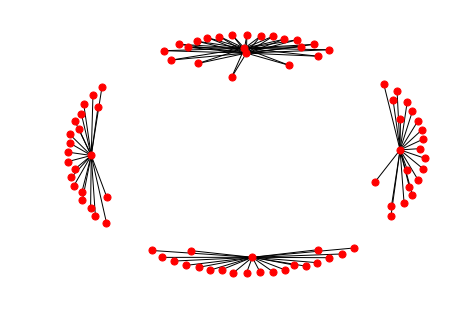

In [41]:
import pickle
import time 
import redis 
import networkx as nx
from matplotlib import pyplot as plt

r = redis.StrictRedis(host='localhost', port=6379, db=0)
plt.clf()

# test out the forest search for similar profiles
iterator = r.scan_iter()
subgraph = nx.Graph()

for i in range(5):
    key = next(iterator)
    hashval = pickle.loads(r.get(key))
    result = forest.query(hashval , 20)    
    subgraph.add_node(key)
    for interactor in result:
        subgraph.add_node(interactor )
        j = hashval.jaccard( pickle.loads(r.get(interactor)) )
        subgraph.add_edge( key , interactor , jaccard = j )

print 'edges'
print subgraph.number_of_edges()
print 'nodes'
print subgraph.number_of_nodes()
print 'components'
print nx.number_connected_components(subgraph)
    

nx.draw(subgraph , node_size = 50)

plt.show()

In [89]:
%%javascript
element.append("<div id='chart1'></div>");



<IPython.core.display.Javascript object>

In [88]:
from IPython.display import Javascript
from networkx.readwrite import json_graph
#runs arbitrary javascript, client-side
data = json_graph.node_link_data(G)
Javascript("""
           window.graphdata={};
           """.format(data)) 

<IPython.core.display.Javascript object>

In [ ]:
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

In [ ]:
#parallel implimentation of graph construction
import multiprocessing as mp
import redis 
import networkx as nx
import gc
import pickle

print 'loading forest'

with open( './ForestALL.pkl', 'r') as forestfile:
    forest = pickle.load(forestfile)
print 'forest loaded'

def worker(q,retq,l,forest, r ):
    while True:
        #make a sugraph for a HOG
        key= q.get()
        if key == 'DONE':
            break
        hashvalkey = pickle.loads(r.get(key))
        l.acquire()
        result = forest.query(hashvalkey,30)
        l.release()
        CoevolutionSubGraph = nx.Graph()
        CoevolutionSubGraph.add_node(key )
        for interactor in result:
            hashvalinteractor = pickle.loads(r.get(interactor))
            CoevolutionSubGraph.add_node(interactor)
            CoevolutionSubGraph.add_edge(key, interactor , jaccard = hashvalkey.jaccard(hashvalinteractor))
        retq.put(CoevolutionSubGraph)
        del CoevolutionSubGraph
        gc.collect()

def updater(q,retq,l ):
    #merge subgraphs
    G = nx.Graph()
    while True:
        subgraph = retq.get()
        if subgraph == 'DONE':
            break
        #union graphs
        G = nx.compose(G,subgraph)
        del subgraph
        gc.collect()
    q.put(G)

lock = mp.Lock()
r = redis.StrictRedis(host='localhost', port=6379, db=0)
iterator = r.scan_iter()
cores = mp.cpu_count()
q = mp.Queue(maxsize=1000)
retq = mp.Queue(maxsize=1000)
processes =[]

for i in range(cores):
    t = mp.Process(target=worker, args=(q,retq,lock ,forest,r)  ) 
    t.daemon = True
    t.start()
    processes.append(t)
u = mp.Process(target=updater, args=(q,retq,lock)  ) 
u.daemon = True
u.start()

for i,data in enumerate(iterator):
    if i % 10000 == 0 :
        print i
    q.put(data)
    
for p in processes:
    q.put('DONE')
retq.put('DONE')
finalgraph = q.get()

with open('graphobj.pkl' , 'w') as graphhandle:
    pickle.dump(Coevolution_1stpass , graphhandle , -1)
    
q.close()
retq.close()

print 'DONE!!!!!'

loading forest
forest loaded
0
100000


In [ ]:
#generate other distance metrics within clusters defined by the jaccard distance cutoff
#get the rows of the matrix from the network neighborhood...
#only calculate edges that don't have metric.
#reassign values to the edges.




#calculate the prob of 0 or the prob of 1 for each row
def prob_x_y_forBinary_M(two_rows):
    px_one = np.sum(two_rows[0,:])/two_rows.shape[1]
    px_zero = 1-px_one
    py_one = np.sum(two_rows[1,:])/two_rows.shape[1]
    py_zero = 1-py_one
    return np.array( [px_zero, px_one]), np.array([py_zero, py_one])

def pxy_coocurrence_between_two_M(m):
    #4 cases for two binary vectors. (x=1,y=1), (x=0,y=1), (x=1,y=0), (x=0,y=0) 
    #use matrix multiplication to get cooccurences between rows for all cases
    pxy_case1 = tf.multiply(m,m.T)/m.shape[1]
    pxy_case2 = tf.multiply(1-m, m.T )/m.shape[1]
    pxy_case3 = tf.multiply(m, 1-m.T)/m.shape[1]
    pxy_case4 =1 -tf.add([pxy_case1, pxy_case2 , pxy_case3])
    #Ncase 4 is whatever is leftover
    return pxy_case1, pxy_case2,pxy_case3, pxy_case4

def MI(probx,proby, cooccurenceMat ):
    #calculate MI of two rows
    px,py = prob_x_y(two_rows)
    pxy = pxy_coocurrence_between_two_rows(two_rows)
    MI=0
    for x in [0,1]:
        for y in [0,1]:
                MI+= pxy[x,y]*np.log( pxy[x,y] / (px[x] * py[y]) ) 
    return MI

def replacementMetric(probx,proby, cooccurenceMat ):
    #calculate only half the MI. when one prot replaces another
    #don't know if this will be useful...emergent mechanisms replacing older stuff...
    
    px,py = prob_x_y(two_rows)
    pxy = pxy_coocurrence_between_two_rows(two_rows)
    MI=0
    for x in [0,1]:
        MI+= pxy[x,1-x]*np.log( pxy[x,1-x] / (px[x] * py[1-x]) ) 
    return MI

def Hamming_dist(cooccurenceMats):
    return coocurrenceMats[1]*coocurrenceMats[1].shape[1]+cooccurenceMats[2]*coocurrenceMats[1].shape[1]


In [ ]:
#run PCA on subset of the data to filter out overrepresented species and project reduced matrix down to species subspace



handle1 =open('./BigCoEvMatrix.pkl' , 'r')
cooevolution_matrix = pickle.load(handle1)
handle1.close()


handle1 = open('./hogs.pkl','r')
handle2= open('./fams.pkl','r')
handle3 = open('./taxa.pkl','r')

Hogs = pickle.load(handle1)
Fams = pickle.load(handle2)
Taxa = pickle.load(handle3)

handle1.close()
handle2.close()
handle3.close()



#manifold is consistent across all hogs? Use random subsample for PCA








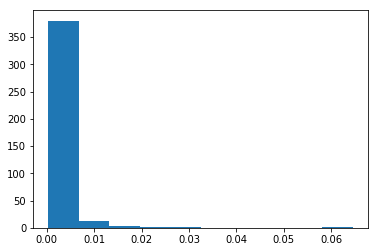

In [16]:
from sklearn.decomposition import TruncatedSVD as svd
import pickle
from matplotlib import pyplot as plt
randHogs = np.random.randint(0,len(Hogs), 10000)
submatrix = cooevolution_matrix[randHogs,:]
SVD = svd(n_components=400)
SVD.fit(submatrix)
plt.hist(SVD.explained_variance_ratio_.T)
plt.show()




In [17]:
print np.sum(SVD.explained_variance_ratio_.T)
print 'variance w/' + str(SVD.n_components) + ' components'



0.840992043543
variance w/400 components


In [ ]:
subT = SVD.transform(submatrix)

from sklearn.manifold import MDS
mds = MDS(n_jobs=-1)
pts = mds.fit_transform(subT)
plt.scatter( pts[:,0], pt[:,1])
plt.show()




In [ ]:

#zp2 hog is.
#HOG:0262715
